# Build your very own custom Classifier

This notebook was copied and modified for this lab from this source https://github.com/fastai/course-v3 

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
# GPU only and squatting on 3
os.environ["CUDA_VISIBLE_DEVICES"]="0"


## About our Class Environment

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.3](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

For this class, we are using WML-CE running in the Worldwide Client Experience Center Cloud, or CECC for short.  To access and environment, simply browse to this website and request a Power8 or Power9 environment.

https://www.ibm.com/it-infrastructure/services/cecc-portal/web/Catalog

* Note : To get PowerAI up and running we have a special setup script in our github repo ... 

https://github.ibm.com/vanstee/aicoc-ai-immersion/blob/master/FastAI/setup_fastai.sh

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
import os

# utility print function
def nprint(mystring) :
    print("**{}** : {}".format(sys._getframe(1).f_code.co_name,mystring))


## Project Configuration

This data structure below will hold all the settings for our class.  Its handy to have a simple dictionary contain all your project settings to keep organized.  We have include an override capability to these default settings so that you can customize your project. 


In [4]:
def getconfig(cfg_in={}):
    cfg = {}
    cfg["bs"] = 16
    cfg["image_dir"] = "/home/cecuser/FastAI/images"
    cfg["utility_dir"] = "/home/cecuser/FastAI"    
    cfg["classes"] = ["cars","busses","trucks"]
    cfg["num_images"] = {"train":200,"valid":20,"test":20}
    cfg["d_partitions"] = list(cfg["num_images"].keys())                 
    cfg["jpeginfo"] ="/home/cecuser/aicoc-ai-immersion/FastAI/jpeginfo"
   
    # overwrite configs if passed
    for (k,v) in cfg_in.items() :
        nprint("Overriding Config {}:{} with {}".format(k,cfg[k],v))
        cfg[k] = v
    return cfg

# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

Here we are going to build our own dataset !!  Think of 3 categories you would like to classify images.  In this example, we will use 
* busses
* trucks 
* cars

We will use an open source tool called *googliser* to download our images from google images.

For a Covid-19 based example you could make your classes something like 
* "people wearing masks"
* "people posing street"



In [28]:
# Overrides for lab
mycfg = {
    "classes":["people wearing masks","people posing street","people skateboarding","people on bikes"],  ## <<- CLASS Enter your search terms here 
    "d_partitions":["train"],
}
cfg=getconfig(mycfg)


**getconfig** : Overriding Config classes:['cars', 'busses', 'trucks'] with ['people wearing masks', 'people posing street', 'people skateboarding', 'people on bikes']
**getconfig** : Overriding Config d_partitions:['train', 'valid', 'test'] with ['train']


## Make Some Directories to hold our data 

FastAI is very flexible and help you label your image data in all sorts of ways.  You might have a bunch of images and a csv file with the labels.  You might have your images organized by folder with the folder name being the labels.  

To see all the supported methods check out this link..
https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder

For our class, we are going to organize our data by folder.

TODO : insert image here ...

In [29]:
# Helpers to make directories
def class_folder_name(base,d_part,cls) :
    return base+"/"+d_part+"/"+ cls.replace(" ","_")

def makeDirIfNotExist(directory) :
    if not os.path.exists(directory):  
        nprint("Making directory {}".format(directory))
        os.makedirs(directory) 
    else :
        nprint("Directory {} already exists .. ".format(directory))

# Build directory hierarchy
#   [train|valid|test ]
#    -----------------> [class1 | class2 | class...]
for d_part in cfg["d_partitions"] :
    for cls in cfg["classes"] :
        directory=class_folder_name(cfg['image_dir'],d_part,cls)
        makeDirIfNotExist(directory)


**makeDirIfNotExist** : Directory /home/cecuser/FastAI/images/train/people_wearing_masks already exists .. 
**makeDirIfNotExist** : Directory /home/cecuser/FastAI/images/train/people_posing_street already exists .. 
**makeDirIfNotExist** : Making directory /home/cecuser/FastAI/images/train/people_skateboarding
**makeDirIfNotExist** : Making directory /home/cecuser/FastAI/images/train/people_on_bikes


## Install Googliser here.  
This handy utility will download our images from google images.  We will clone the repo from git.

In [30]:
# install googliser
def install_googliser():
    googliser_directory = cfg['utility_dir']+"/googliser"
    if not os.path.exists(googliser_directory):  
        nprint("Installing Googliser here : {} ".format(googliser_directory))
        os.chdir(cfg['utility_dir'])
        !git clone https://github.com/teracow/googliser
    else :
        nprint("Googliser already installed here : {} ".format(googliser_directory))

    googliser = cfg['utility_dir']+"/googliser/googliser.sh"

    return googliser 
googliser = install_googliser()
!ls {googliser}

**install_googliser** : Googliser already installed here : /home/cecuser/FastAI/googliser 
/home/cecuser/FastAI/googliser/googliser.sh


## How many images should we grab ?

Luckily not too many.. it always depends on the project, but we are going to use a pre-training deep learning network when we perform training.  Since that network was already trained on over 1 million images, we don't need to supply too many for our task.  This is why transfer learning is so powerful!

In [8]:
cfg['num_images']

{'train': 200, 'valid': 20, 'test': 20}

In [31]:
# The code below will download files to train folder only to avoid duplicate downloads.  
# We then move a few files over.  This can be done manually or programatically.  For our example
# we will let FastAI do the work for us!

def download_images(cfg):
    utility_dir = cfg['utility_dir']
    for d_p in cfg["d_partitions"] : # train only for now ..
        for cls in cfg["classes"] :
            current_dir =class_folder_name(cfg['image_dir'],d_p,cls)
            #os.chdir(current_dir)
            os.chdir(utility_dir)
            command = googliser + \
                      " --o {}".format(current_dir) +\
                      " --phrase \"{}\"".format(cls) + \
                      " --parallel 50 --upper-size 500000 --lower-size 2000 " + \
                      " -n {}".format(cfg['num_images'][d_p]) + \
                      " --format jpg  --safesearch-off -z"
            #--timeout 15
            nprint(command)
            !{command}
    nprint("Downloads complete!")
download_images(cfg)
# for cls in classes :
#     print("Download {} training images to {}".format(cls,traindir))
#     ! {c['image_dir']}/googliser/googliser.sh --phrase {cls} --title {cls} --parallel 10 \
#       --upper-size 500000 --lower-size 2000  -n {c['num_images']} --quiet \
#        --format png
# os.chdir(valdir)
# for cls in classes :
#     print("Download {} validation images to {}".format(cls,valdir))
#     ! {c['image_dir']}/googliser/googliser.sh --phrase {cls} --title {cls} --parallel 10 --upper-size 500000 --lower-size 2000  -n 5 --quiet
# 
#!../googliser/googliser.sh --phrase "trucks" --title "trucks" --parallel 10 --upper-size 500000 --lower-size 2000  -n 30 --quiet
#!../googliser/googliser.sh --phrase "motorcycles" --title "motorcycles" --parallel 10 --upper-size 500000 --lower-size 2000  -n 30 --quiet


**download_images** : /home/cecuser/FastAI/googliser/googliser.sh --o /home/cecuser/FastAI/images/train/people_wearing_masks --phrase "people wearing masks" --parallel 50 --upper-size 500000 --lower-size 2000  -n 200 --format jpg --timeout 15
 googliser.sh v:200212 PID:2414

   Google: 0/10 web pages OK, 1/10 are in progres0/10 web pages OK, 2/10 are in progres0/10 web pages OK, 3/10 are in progres0/10 web pages OK, 4/10 are in progres0/10 web pages OK, 5/10 are in progres0/10 web pages OK, 6/10 are in progres0/10 web pages OK, 7/10 are in progres0/10 web pages OK, 8/10 are in progres0/10 web pages OK, 9/10 are in progres0/10 web pages OK, 10/10 are in progress10 web pages OK                         
    links: 73 

 Try your search again with additional options:
    - disable SafeSearch: '--safesearch-off'



 download: 0/73 images OK0/73 images OK, 1/50 are in progress0/73 images OK, 2/50 are in progress0/73 images OK, 3/50 are in progress0/73 images OK, 4/50 are in progress0/73 images OK, 5/50 are in progress0/73 images OK, 6/50 are in progress0/73 images OK, 7/50 are in progress0/73 images OK, 8/50 are in progress0/73 images OK, 9/50 are in progress0/73 images OK, 10/50 are in progres0/73 images OK, 11/50 are in progres0/73 images OK, 12/50 are in progres0/73 images OK, 13/50 are in progres0/73 images OK, 14/50 are in progres0/73 images OK, 15/50 are in progres0/73 images OK, 16/50 are in progres0/73 images OK, 17/50 are in progres0/73 images OK, 17/50 are in progress and 1 have faile0/73 images OK, 18/50 are in progress and 1 have faile0/73 images OK, 19/50 are in progress and 2 have faile1/73 images OK, 19/50 are in progress and 3 have faile3/73 images OK, 16/50 are in progress and 5 have faile3/73 images OK, 17/50 are in progress and 5 have faile4/73 images OK, 17/50 are in progress a

41/73 images OK and 32 failed                           links list exhausted!
**download_images** : /home/cecuser/FastAI/googliser/googliser.sh --o /home/cecuser/FastAI/images/train/people_posing_street --phrase "people posing street" --parallel 50 --upper-size 500000 --lower-size 2000  -n 200 --format jpg --timeout 15
 googliser.sh v:200212 PID:4076

   Google: 0/10 web pages OK, 1/10 are in progres0/10 web pages OK, 2/10 are in progres0/10 web pages OK, 3/10 are in progres0/10 web pages OK, 4/10 are in progres0/10 web pages OK, 5/10 are in progres0/10 web pages OK, 6/10 are in progres0/10 web pages OK, 7/10 are in progres0/10 web pages OK, 8/10 are in progres0/10 web pages OK, 9/10 are in progres0/10 web pages OK, 10/10 are in progress10 web pages OK                         
    links: 86 

 Try your search again with additional options:
    - disable SafeSearch: '--safesearch-off'



 download: 0/86 images OK0/86 images OK, 1/50 are in progress0/86 images OK, 2/50 are in progress0/86 images OK, 3/50 are in progress0/86 images OK, 4/50 are in progress0/86 images OK, 5/50 are in progress0/86 images OK, 6/50 are in progress0/86 images OK, 7/50 are in progress0/86 images OK, 8/50 are in progress0/86 images OK, 9/50 are in progress0/86 images OK, 10/50 are in progres0/86 images OK, 11/50 are in progres0/86 images OK, 12/50 are in progres0/86 images OK, 13/50 are in progres0/86 images OK, 14/50 are in progres0/86 images OK, 15/50 are in progres0/86 images OK, 16/50 are in progres0/86 images OK, 17/50 are in progres0/86 images OK, 17/50 are in progress and 1 have faile0/86 images OK, 18/50 are in progress and 1 have faile2/86 images OK, 18/50 are in progress and 1 have faile3/86 images OK, 17/50 are in progress and 1 have faile3/86 images OK, 18/50 are in progress and 1 have faile7/86 images OK, 15/50 are in progress and 1 have faile7/86 images OK, 16/50 are in progress a

67/86 images OK, 8/50 are in progress and 11 have failed68/86 images OK, 7/50 are in progress and 11 have failed69/86 images OK, 7/50 are in progress and 11 have failed69/86 images OK, 6/50 are in progress and 11 have failed71/86 images OK, 4/50 are in progress and 11 have failed72/86 images OK, 3/50 are in progress and 11 have failed73/86 images OK, 3/50 are in progress and 11 have failed73/86 images OK, 2/50 are in progress and 11 have failed74/86 images OK, 1/50 are in progress and 11 have failed74/86 images OK and 12 failed                           links list exhausted!
**download_images** : /home/cecuser/FastAI/googliser/googliser.sh --o /home/cecuser/FastAI/images/train/people_skateboarding --phrase "people skateboarding" --parallel 50 --upper-size 500000 --lower-size 2000  -n 200 --format jpg --timeout 15
 googliser.sh v:200212 PID:31603

   Google: 0/10 web pages OK, 1/10 are in progres0/10 web pages OK, 2/10 are in progres0/10 web pages OK, 3/10 are in progres0/10 web pages 

 download: 0/78 images OK0/78 images OK, 1/50 are in progress0/78 images OK, 2/50 are in progress0/78 images OK, 3/50 are in progress0/78 images OK, 4/50 are in progress0/78 images OK, 5/50 are in progress0/78 images OK, 6/50 are in progress0/78 images OK, 7/50 are in progress0/78 images OK, 8/50 are in progress0/78 images OK, 9/50 are in progress0/78 images OK, 10/50 are in progres0/78 images OK, 11/50 are in progres0/78 images OK, 12/50 are in progres0/78 images OK, 13/50 are in progres0/78 images OK, 14/50 are in progres0/78 images OK, 15/50 are in progres0/78 images OK, 16/50 are in progres0/78 images OK, 17/50 are in progres0/78 images OK, 18/50 are in progres0/78 images OK, 19/50 are in progres0/78 images OK, 19/50 are in progress and 1 have faile2/78 images OK, 18/50 are in progress and 1 have faile2/78 images OK, 18/50 are in progress and 2 have faile2/78 images OK, 19/50 are in progress and 2 have faile4/78 images OK, 17/50 are in progress and 3 have faile4/78 images OK, 18/50

54/78 images OK, 9/50 are in progress and 16 have failed54/78 images OK, 8/50 are in progress and 16 have failed54/78 images OK, 7/50 are in progress and 17 have failed55/78 images OK, 6/50 are in progress and 17 have failed55/78 images OK, 5/50 are in progress and 18 have failed55/78 images OK, 4/50 are in progress and 19 have failed55/78 images OK, 3/50 are in progress and 20 have failed55/78 images OK, 2/50 are in progress and 21 have failed55/78 images OK, 1/50 are in progress and 22 have failed55/78 images OK and 23 failed                           links list exhausted!
**download_images** : /home/cecuser/FastAI/googliser/googliser.sh --o /home/cecuser/FastAI/images/train/people_on_bikes --phrase "people on bikes" --parallel 50 --upper-size 500000 --lower-size 2000  -n 200 --format jpg --timeout 15
 googliser.sh v:200212 PID:25224

   Google: 0/10 web pages OK, 1/10 are in progres0/10 web pages OK, 2/10 are in progres0/10 web pages OK, 3/10 are in progres0/10 web pages OK, 4/10 a

 download: 0/82 images OK0/82 images OK, 1/50 are in progress0/82 images OK, 2/50 are in progress0/82 images OK, 3/50 are in progress0/82 images OK, 4/50 are in progress0/82 images OK, 5/50 are in progress0/82 images OK, 5/50 are in progress and 1 have failed0/82 images OK, 6/50 are in progress and 1 have failed0/82 images OK, 7/50 are in progress and 1 have failed0/82 images OK, 8/50 are in progress and 1 have failed0/82 images OK, 9/50 are in progress and 1 have failed1/82 images OK, 9/50 are in progress and 1 have failed1/82 images OK, 10/50 are in progress and 1 have faile1/82 images OK, 11/50 are in progress and 1 have faile1/82 images OK, 12/50 are in progress and 1 have faile1/82 images OK, 13/50 are in progress and 1 have faile1/82 images OK, 14/50 are in progress and 1 have faile1/82 images OK, 15/50 are in progress and 1 have faile1/82 images OK, 16/50 are in progress and 1 have faile1/82 images OK, 17/50 are in progress and 1 have faile2/82 images OK, 17/50 are in progress a

45/82 images OK, 18/50 are in progress and 19 have faile46/82 images OK, 17/50 are in progress and 19 have faile48/82 images OK, 17/50 are in progress and 19 have faile48/82 images OK, 14/50 are in progress and 20 have faile49/82 images OK, 13/50 are in progress and 20 have faile50/82 images OK, 12/50 are in progress and 20 have faile51/82 images OK, 11/50 are in progress and 20 have faile53/82 images OK, 9/50 are in progress and 20 have failed54/82 images OK, 8/50 are in progress and 20 have failed55/82 images OK, 7/50 are in progress and 20 have failed56/82 images OK, 6/50 are in progress and 20 have failed57/82 images OK, 5/50 are in progress and 20 have failed57/82 images OK, 5/50 are in progress and 21 have failed57/82 images OK, 4/50 are in progress and 21 have failed57/82 images OK, 4/50 are in progress and 22 have failed57/82 images OK, 3/50 are in progress and 22 have failed57/82 images OK, 3/50 are in progress and 23 have failed57/82 images OK, 2/50 are in progress and 23 hav

## Clean up downloaded images that are not proper jpeg format ..

In [45]:
# clean with jpeginfo! 
def clean_up_bad_jpegs(cfg):
    os.chdir(cfg['image_dir'])
    nprint("Search for Error files in {}......".format(cfg['image_dir']))
    # handle both jpg //jpeg
    command = "find . -name \"*.jpe*g\" | xargs -i {}".format(cfg["jpeginfo"]) +\
              " -c {} | grep ERROR"
    nprint("Running command : {}".format(command))
    !{command}
    nprint("Removing any error files listed above")
    command = command + ' | cut -d " " -f1 | xargs -i rm {} '
    nprint("Running command : {}".format(command))
    !{command}
    nprint("Done")
clean_up_bad_jpegs(cfg)
# find . -name "*.jpg" | xargs -i ./jpeginfo -c {}
# find . -name "*.jpg" | xargs -i ./jpeginfo -c {} | grep ERROR | cut -d " " -f1 | xargs -i rm {}

**clean_up_bad_jpegs** : Search for Error files in /home/cecuser/FastAI/images......
**clean_up_bad_jpegs** : Running command : find . -name "*.jpe*g" | xargs -i /home/cecuser/aicoc-ai-immersion/FastAI/jpeginfo -c {} | grep ERROR
./train/people_skateboarding/image(0004).jpeg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
**clean_up_bad_jpegs** : Removing any error files listed above
**clean_up_bad_jpegs** : Running command : find . -name "*.jpe*g" | xargs -i /home/cecuser/aicoc-ai-immersion/FastAI/jpeginfo -c {} | grep ERROR | cut -d " " -f1 | xargs -i rm {} 
**clean_up_bad_jpegs** : Done


In [46]:
#path = untar_data(URLs.PETS); path
path = Path(cfg['image_dir'])

In [47]:
path.ls()
#cfg['image_dir']

[PosixPath('/home/cecuser/FastAI/images/train'),
 PosixPath('/home/cecuser/FastAI/images/models')]

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

## Create Data Bunch
Fastai has a number of methods to create a data bunch. Lets look at some of the documentation using **doc** function

In [48]:
#doc(ImageDataBunch)
doc(ImageDataBunch.from_folder)

In [49]:
# https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder
## Important, batch size should be set lower than the number of images you have
data = ImageDataBunch.from_folder(path=cfg['image_dir'],
                train="train",valid_pct=0.20,no_check=True,
                size=224,num_workers=4,bs=cfg["bs"]).normalize(imagenet_stats)
# data=None
# try :
# except OSError as err: 
#     print("OS error: {0}".format(err))
    
#/gpfs/home/s4s004/vanstee/anaconda3/envs/powerai-fastai/lib/python3.7/site-packages/fastai/basic_data.py:262: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in 
#            self.train_ds: 24,33,47,70,32
#  warn(warn_msg)


In [50]:
data

ImageDataBunch;

Train: LabelList (191 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
people_wearing_masks,people_wearing_masks,people_wearing_masks,people_wearing_masks,people_wearing_masks
Path: /home/cecuser/FastAI/images;

Valid: LabelList (47 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
people_skateboarding,people_posing_street,people_wearing_masks,people_posing_street,people_wearing_masks
Path: /home/cecuser/FastAI/images;

Test: None

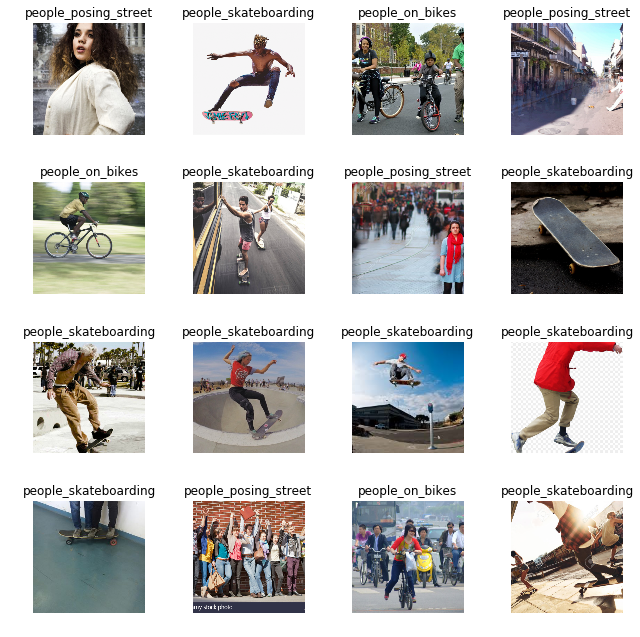

In [38]:
data.show_batch(rows=4, figsize=(9,9))
#data.show_batch(figsize=(4,4))

In [21]:
data.label_list

LabelLists;

Train: LabelList (104 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
people_wearing_masks,people_wearing_masks,people_wearing_masks,people_wearing_masks,people_wearing_masks
Path: /home/cecuser/FastAI/images;

Valid: LabelList (26 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
people_wearing_masks,people_posing_street,people_wearing_masks,people_posing_street,people_wearing_masks
Path: /home/cecuser/FastAI/images;

Test: None

In [39]:
print(data.classes)
len(data.classes),data.c

['people_on_bikes', 'people_posing_street', 'people_skateboarding', 'people_wearing_masks']


(4, 4)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).


In [75]:
#create learner
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [76]:
# save pretrained model ..
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [77]:
# dont worry about the #na#, as long as we get a plot in the next section, great!
learn.lr_find() # num_it=36, stop_div=False

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


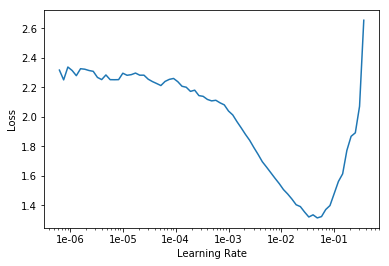

In [79]:
learn.recorder.plot()

In [80]:
# Run 5 epochs (can do more if still getting better train / val)
# FILL IN THE RANGE BASE ON YOUR LRFIND RESULT
learn.fit_one_cycle(5, max_lr=slice(5e-5,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.484528,0.989543,0.234043,00:10
1,1.049889,0.532590,0.170213,00:09
2,0.785293,0.628661,0.170213,00:10
3,0.568524,0.695996,0.191489,00:10
4,0.440341,0.694865,0.170213,00:10


## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, if we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [81]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [69]:
doc(interp.plot_top_losses)

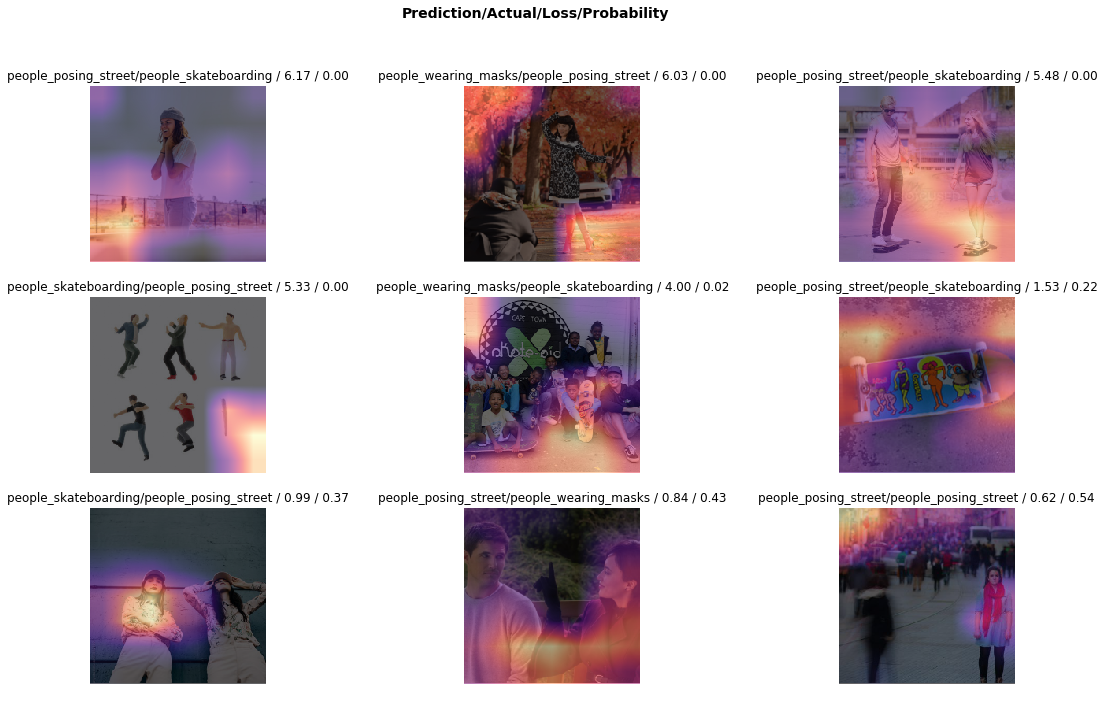

In [82]:
interp.plot_top_losses(9, figsize=(19,11),heatmap=True)

array([[12,  0,  0,  0],
       [ 0, 14,  2,  1],
       [ 0,  3,  5,  1],
       [ 0,  1,  0,  8]])

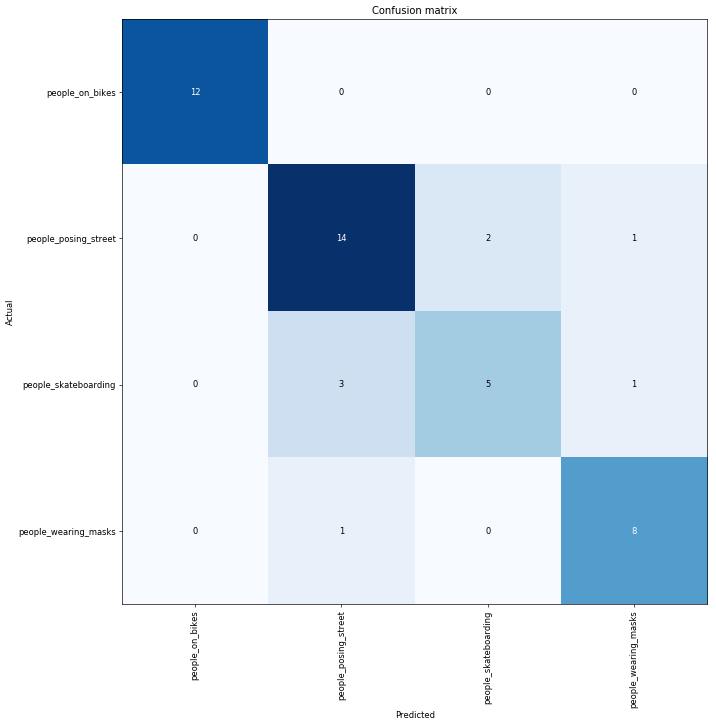

In [83]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.confusion_matrix()

In [73]:
interp.most_confused(min_val=2)

[('people_posing_street', 'people_skateboarding', 2),
 ('people_skateboarding', 'people_posing_street', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [84]:
learn.save('stage-1')
learn.unfreeze()

In [86]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.413045,1.734968,0.212766,00:10
1,0.505225,1.368340,0.148936,00:10
2,0.524361,1.845231,0.276596,00:09
3,0.400105,0.848856,0.191489,00:10
4,0.349806,0.703963,0.127660,00:10


In [87]:
#learn.save('stage-2')
#learn.load('stage-1');
#learn.unfreeze(-2)
#learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

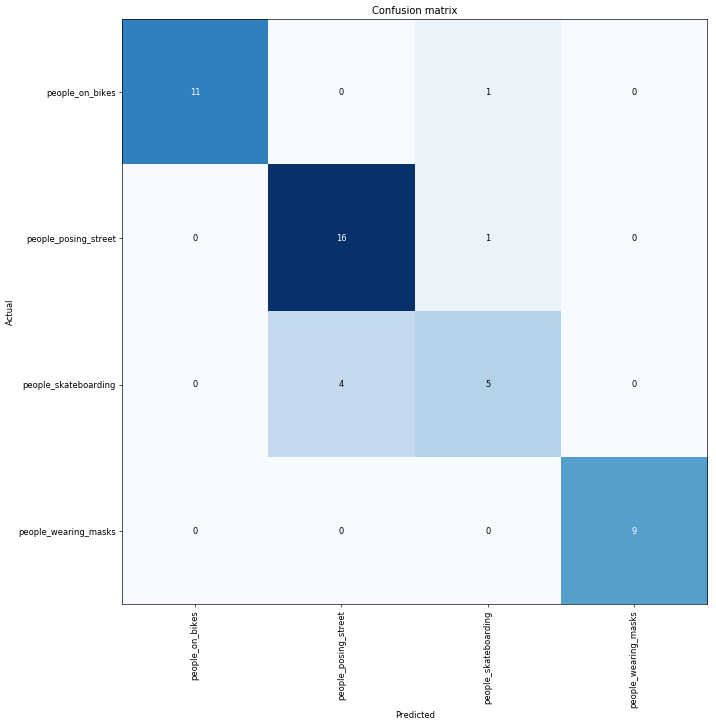

In [88]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

## Optional Assignment 
Can you redo the training above with a different pre-trained model ???  See this page for some ideas

https://docs.fast.ai/vision.models.html

* Hint : in a a code cell type  models.\<<tab\>>

In [ ]:
doc(cnn_learner)

In [ ]:
#learn = cnn_learner(data, FILL_IN_HERE!!, metrics=error_rate)
learn = cnn_learner(data, models.vgg11_bn, metrics=error_rate)
# model.alexnet

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2) # 2 epochs ...

In [ ]:
learn.save('stage-1-custom')

## Lets continue to tune ...

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't get better results, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

## Other data formats -- Loading Data from PAIV // IVI For example

So you want to train on some data that maybe you labelled in another tool ?  No problem.  Here we show how you could read in data exported from PAIV and classifying in this tool ...

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes